## **Cámaras Galería de arte**

En una galería de arte cuyo plano es el de la figura, se desean instalar cámaras de video para tenerla completamente vigilada. Hay 9 zonas A, B, . . . , I, y 9 posibles puntos 1, . . . , 9 de instalación de las cámaras. Una cámara colocada en cualquiera de los puntos señalados vigila todas las zonas adyacentes a dicho punto. Por ejemplo, una cámara en el punto 3 vigila las zonas A y B y una cámara en el punto 8 vigila las zonas B, F, G y C. Todas la zonas deben está vigilidas por al menos una cámara.

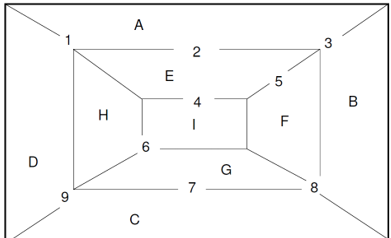

Por requerimientos tecnológicos, si se sitúan cámaras en los puntos 2,3 y 4, estas cámaras costarían $5, $7 y $8. Para los otros puntos, una cámara de valor de $2 cumpliría con los requerimientos.

Se tienen los siguientes requerimientos
1.	El número de cámaras que vigilan G debe ser mayor al número de cámaras que vigilan B
2.	Si se instala una cámara en 6 y no se instala cámara en 3 entonces se debe instalar una cámara en 9
3.	No se puede tener más que 3 cámaras que vigilan el sector constituido por las zonas A y B

La transmisión de los datos entre cámaras se hace mediante una red wifi. Los datos de grabación llegan a un router wifi común. La galería quiere saber dónde instalar el router y las cámaras teniendo en cuenta que: 
-	El router wifi solo se puede instalar en uno de los 9 puntos de instalación de cámaras.
-	El router wifi no se puede instalar en un punto donde hay una cámara.
-	Cada cámara se conecta directamente al router wifi. El nivel de radiaciones que genera la conexión es proporcional a la distancia entre la cámara y el router y vale 15 unidades de radiación/metro. Las distancias entre los puntos se muestran en la tabla siguiente.

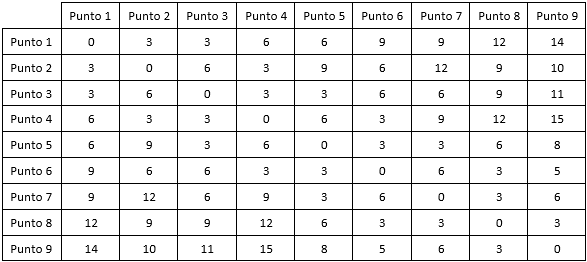

Formula el correspondiente modelo en programación lineal en FORMA COMPACTA para determinar dónde se deben instalar las cámaras de manera que se minimice el costo total de instalación de cámaras y la suma total de las radiaciones generadas por las conexiones entre cada cámara y el router wifi.

In [1]:
import pandas
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
df_punto_zona = pandas.read_excel("./data.xlsx", sheet_name="Punto Zona", index_col=0)
df_costo_instalacion = pandas.read_excel("./data.xlsx", sheet_name="Costo Instalación")
df_distancias = pandas.read_excel("./data.xlsx", sheet_name="Distancias", index_col=0)

**Conjuntos**


$$ P: \text{Puntos} = \{1, 2, 3, 4, 5, 6, 7, 8, 9\}$$
$$ Z: \text{Zonas} = \{\text{A, B, C, D, E, F, G, H, I}\} $$

In [3]:
PUNTOS = df_punto_zona.index.to_list()
ZONAS = df_punto_zona.columns.to_list()

**Parámetros**


$$ \alpha_{p,z} = \left\{ \begin{array}{cl}
1:\text{Si la camara del punto } p\in P \text{ vigila la zona } z\in Z \\
0:\text{dlc}
\end{array} \right. $$
$$ \text{Costo\_Instalacion}_{p}: \text{Costo de instalar una cámara en un punto } p\in P $$
$$ \text{Distancia}_{p1,p2}: \text{Distancia en metros de un punto } p1\in P \text{ a un punto } p2\in P $$

In [4]:
COSTO_INSTALACION = df_costo_instalacion.set_index("Punto")["Costo Instalación"].to_dict()
ALPHA = df_punto_zona.to_dict("index")
DISTANCIA = df_distancias.to_dict("index")

In [5]:
model = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-28


**Variables de decisión**


$$ x_{p} = \left\{ \begin{array}{cl}
1:\text{Si instalo una cámara en el punto } p\in P \\
0:\text{dlc}
\end{array} \right. $$

$$ y_{p} \in \mathbb{Z}:  \text{Cantidad de cámaras que vigilan la zona } z\in Z $$

$$ w_{p} = \left\{ \begin{array}{cl}
1:\text{Si instalo el router wi-fi en el punto } p\in P \\
0:\text{dlc}
\end{array} \right. $$

In [6]:
x = model.addVars(PUNTOS, vtype=GRB.BINARY, name="x")
y = model.addVars(ZONAS, vtype=GRB.INTEGER, name="y")
w = model.addVars(PUNTOS, vtype=GRB.BINARY, name="w")

**Función Objetivo**


$$ \text{minimizar } \text{FO} = \sum_{p\in P} \text{Costo\_Instalacion}_{p} \times x_{p} + \sum_{p1\in P} \sum_{p2\in P} 15 \times \text{Distancia}_{p1,p2} \times w_{p1} $$

In [7]:
costo_instalacion_camara = gp.quicksum(COSTO_INSTALACION[punto] * x[punto] for punto in PUNTOS)
radiacion_wifi = gp.quicksum(
    15 * DISTANCIA[punto1][punto2] * w[punto1]
    for punto1 in PUNTOS
    for punto2 in PUNTOS
)

## OPC1: FO una expresión
# model.setObjective(costo_instalacion_camara + radiacion_wifi, GRB.MINIMIZE)

## OPC2: FO multiobjetivo
model.setObjectiveN(costo_instalacion_camara, index=0, priority=2, weight=1)
model.setObjectiveN(radiacion_wifi, index=1, priority=1, weight=1)
model.ModelSense = GRB.MINIMIZE

**Restricciones**


$$ \forall z\in Z:y_{z} = \sum_{p\in P}\alpha_{pz} \times x_{p} $$

In [8]:
for zona in ZONAS:
    model.addConstr(y[zona] == gp.quicksum(ALPHA[punto][zona] * x[punto] for punto in PUNTOS))

$$ \forall z\in Z:y_{z} \ge 1 $$

In [9]:
for zona in ZONAS:
    model.addConstr(y[zona] >= 1)

$$ y_{B} \ge  y_{G} - 1 $$
$$ x_{9} \ge  x_{6} + (1 - x_{3}) - 1 $$
$$ x_{1} + x_{2} + x_{3} + x_{8} \le  3 $$

In [10]:
model.addConstr(y["B"] >= y["G"] - 1)
model.addConstr(x[9] >= x[6] + (1 - x[3]) - 1)
model.addConstr(x[1] + x[2] + x[3] + x[8] <= 3)

<gurobi.Constr *Awaiting Model Update*>

$$ \sum_{p\in P}w_{p} =1 $$

In [11]:
model.addConstr(gp.quicksum(w[punto] for punto in PUNTOS) == 1)

<gurobi.Constr *Awaiting Model Update*>

$$ \forall p\in P:w_{p} \le 1 - x_{p} $$

In [12]:
for punto in PUNTOS:
    model.addConstr(w[punto] <= 1 - x[punto])

In [13]:
model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31 rows, 27 columns and 75 nonzeros
Model fingerprint: 0xbef1cd56
Variable types: 0 continuous, 27 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 15 rows and 7 columns
Presolve time: 0.02s
Presolved: 16 rows, 20 columns, 49 nonzeros
------

In [14]:
costo_instalacion_camara.getValue()

10.0

In [15]:
radiacion_wifi.getValue()

705.0

In [16]:
plt.style.use("ggplot")

In [17]:
# Definiendo Grafo
G = nx.Graph()

# Añadiendo nodos de cámaras y zonas
G.add_nodes_from(list(map(str, PUNTOS)))
G.add_nodes_from(ZONAS)

# Construyendo aristas
edges = []
for punto, covertura in ALPHA.items():
    for zone, vigila in covertura.items():
        if vigila == 1:
            edges.append((str(punto), zone))

# Añadiendo aristas al grafo
G.add_edges_from(edges)

# Configurando el diseño para la visualización del grafo
pos_alpha = nx.spring_layout(G, seed=43)  # Usando el diseño de resorte (spring layout)


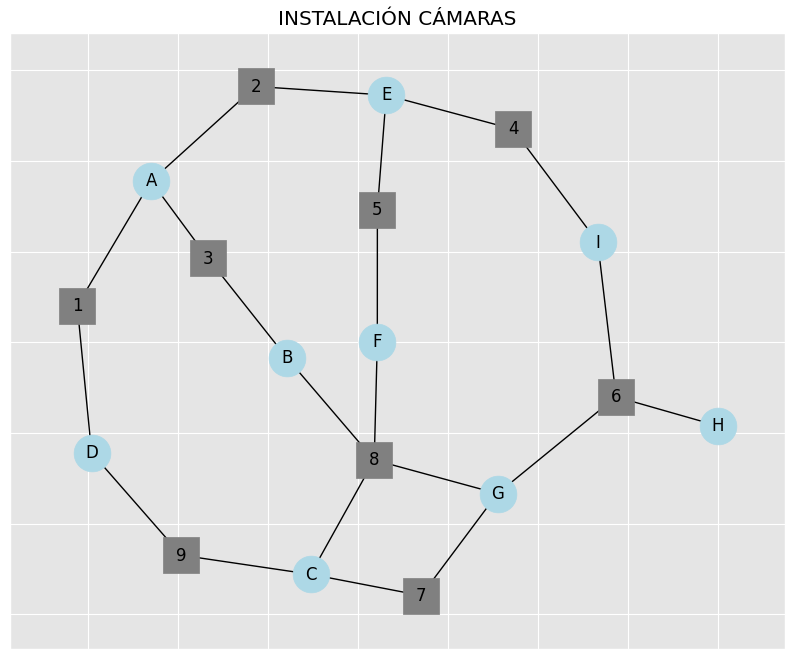

In [18]:
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos_alpha, nodelist=ZONAS, node_color="lightblue", node_size=700)
nx.draw_networkx_nodes(G, pos_alpha, node_shape="s", nodelist=list(map(str, PUNTOS)), node_color="gray", node_size=700)

nx.draw_networkx_labels(G, pos_alpha)
nx.draw_networkx_edges(G, pos_alpha)

plt.title("INSTALACIÓN CÁMARAS")
plt.show()

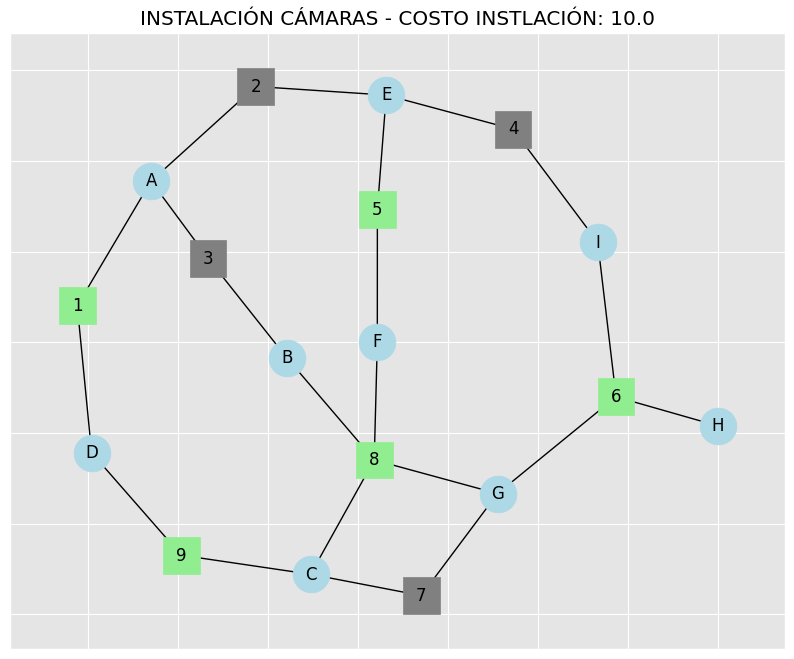

In [19]:
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos_alpha, nodelist=ZONAS, node_color="lightblue", node_size=700)
nx.draw_networkx_nodes(G, pos_alpha, node_shape="s", nodelist=list(map(str, PUNTOS)), node_color=["lightgreen" if x[punto].X > 0.9 else "gray" for punto in PUNTOS], node_size=700)

nx.draw_networkx_labels(G, pos_alpha)
nx.draw_networkx_edges(G, pos_alpha)

plt.title(f"INSTALACIÓN CÁMARAS - COSTO INSTLACIÓN: {costo_instalacion_camara.getValue()}")
plt.show()

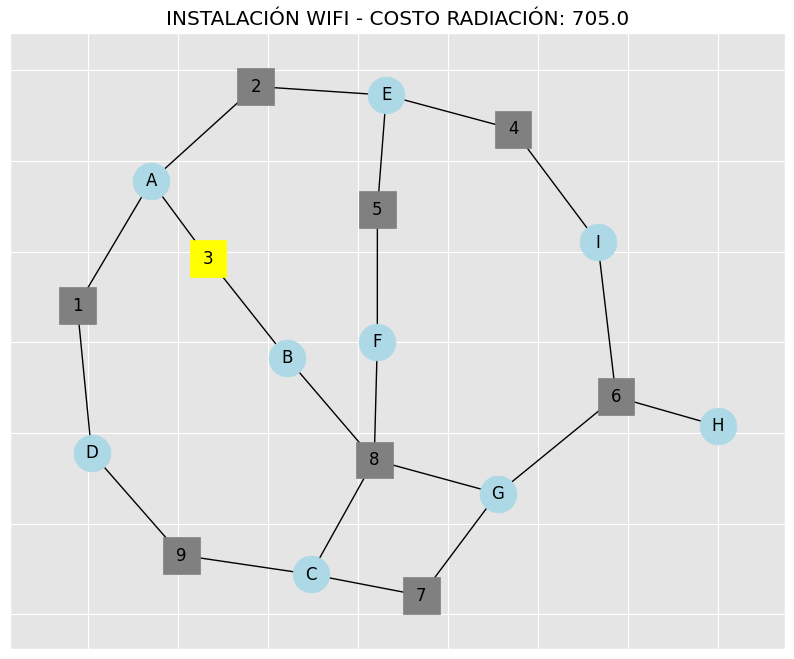

In [20]:
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos_alpha, nodelist=ZONAS, node_color="lightblue", node_size=700)
nx.draw_networkx_nodes(G, pos_alpha, node_shape="s", nodelist=list(map(str, PUNTOS)), node_color=["yellow" if w[punto].X > 0.9 else "gray" for punto in PUNTOS], node_size=700)

nx.draw_networkx_labels(G, pos_alpha)
nx.draw_networkx_edges(G, pos_alpha)

plt.title(f"INSTALACIÓN WIFI - RADIACIÓN WIFI: {radiacion_wifi.getValue()}")
plt.show()

In [21]:
# Crear la figura
fig = go.Figure()

# Agregar bordes
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos_alpha[edge[0]]
    x1, y1 = pos_alpha[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode="lines", line=dict(width=2, color="gray"), hoverinfo="none", showlegend=False))

# Agregar nodos de ZONAS
for zona in ZONAS:
    coord_x, coord_y = pos_alpha[zona]
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="markers", marker=dict(size=40, color="lightblue"), name="Zonas", text=[zona], hoverinfo="text"))

# Agregar nodos de PUNTOS
for punto in PUNTOS:
    coord_x, coord_y = pos_alpha[str(punto)]
    color = "silver"
    if x[punto].X > 0.9:
        color = "lightgreen"
    if w[punto].X > 0.9:
        color = "yellow"
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="markers", marker=dict(size=30, color=color, symbol="square"), name="Puntos", text=[str(punto)], hoverinfo="text"))

# Agregar etiquetas
for node, (coord_x, coord_y) in pos_alpha.items():
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="text", text=[node], textposition="middle center", hoverinfo="none", showlegend=False))



fig.update_layout(
    title=f"INSTALACIÓN CAMARAS <br /> COSTO INSTLACIÓN: {costo_instalacion_camara.getValue()} - RADIACIÓN WIFI: {radiacion_wifi.getValue()}",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    width=800,
    height=650,
    template="ggplot2",
)

# Mostrar la figura
fig.show()